# Pu-238 Maker

In this notebook I will experiment with the OpenMC tools needed to estimate Pu-238 production rate due to irradiation of a NpO2/Al cermet target.  

In [1]:
import openmc
import openmc.deplete # will be needed for depletion analysis eventually
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Materials

While I would expect the driver fuel pins (or other driver fuel forms) will be of relatively easy to define composition, I do not have a firm grasp on the composition of the NpO2/Al CERMET target. What follows is my best guess based on information provided in: 

Howard, Richard H. Overview of the Plutonium-238 Supply Program's CERMET Production Target. Oak Ridge National Lab.(ORNL), Oak Ridge, TN (United States), 2019.

In [2]:
NpO2 = openmc.Material();
NpO2.add_nuclide('Np237',1);
NpO2.add_element('O',2);
NpO2.set_density('g/cc',11.143);

Al = openmc.Material();
Al.add_element('Al',1);
Al.set_density('g/cc',2.7);


target = openmc.Material.mix_materials([NpO2,Al],[0.2,0.7],'vo'); 
# note: 10% is void so expect to get a UserWarning on this.


/home/sblair/miniconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/material.py:1177: UserWarning: Warning: sum of fractions do not add to 1, void fraction set to 0.10000000000000009
  warnings.warn(msg)


In [3]:
print(target.get_nuclide_atom_densities());

OrderedDict([('Np237', 0.004988479277370189), ('O16', 0.009973177287448133), ('O17', 3.781267292246604e-06), ('Al27', 0.042183829047439676)])


In [4]:
print(target.get_mass_density())

4.1186


I think this is at least reasonable.  

## Cross Section Data Info

The goal of this section is to provide a portable example of how one can access and (at a minimum) plot cross section data.  We will use some Python libraries but this method hinges on the environment variable that must be set in order to run OpenMC; namely OPENMC_CROSS_SECTIONS.  

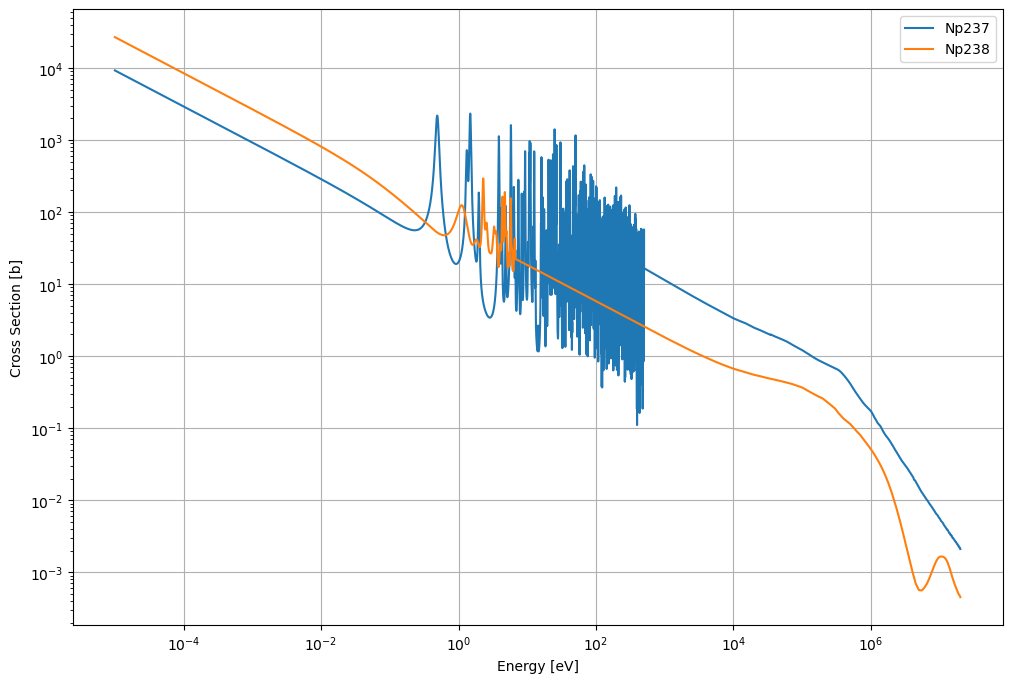

In [5]:
import os
from pathlib import PurePath


p = PurePath(os.environ.get('OPENMC_CROSS_SECTIONS'));#path to cross_sections.xml
omc_data_path = str(p.parents[0]);# path to folder containing cross_sections.xml

np237_path = omc_data_path + "/Np237.h5"; # path to Np-237 cross section data.
np237_data = openmc.data.IncidentNeutron.from_hdf5(np237_path);

np238_path = omc_data_path + "/Np238.h5";
np238_data = openmc.data.IncidentNeutron.from_hdf5(np238_path);

# get cross section data for U-238; this will impact the neutron flux spectrum
# in the fuel pins
u238_path = omc_data_path + "/U238.h5"; 
u238_data = openmc.data.IncidentNeutron.from_hdf5(u238_path);

# cross section data is indexed by the ENDF MT numbers.
# get endf MT numbers from: https://t2.lanl.gov/nis/endf/mts.html
np237_capture = np237_data[102]; #MT = 102 corresponds to radiative capture.
np238_capture = np238_data[102];
u238_capture = u238_data[102];


plt.rcParams['figure.figsize']=[12,8];
plt.loglog(np237_capture.xs['294K'].x,np237_capture.xs['294K'].y,label='Np237');
# see below for guidance on finding temperatures (e.g. '294K') at which
# cross section data is available.
plt.loglog(np238_capture.xs['294K'].x,np238_capture.xs['294K'].y,label='Np238');
plt.grid();
plt.legend();
plt.xlabel('Energy [eV]');
plt.ylabel('Cross Section [b]');


I'm not immediately sure what this tells us except that I think it's notable that Np-238 has a higher capture cross section than Np-237 at thermal energies.  Is there an advantage to using intermediate/higher neutron energy to limit the extent to which Np-238 that we create gets converted to Np-239?

In [6]:
# get list of temperatures available for each reaction by examining the xs attribute:
print(np237_capture.xs);

{'1200K': <openmc.data.function.Tabulated1D object at 0x1546e6462f10>, '2500K': <openmc.data.function.Tabulated1D object at 0x1546e6462eb0>, '250K': <openmc.data.function.Tabulated1D object at 0x1546e6462f40>, '294K': <openmc.data.function.Tabulated1D object at 0x1546e6447cd0>, '600K': <openmc.data.function.Tabulated1D object at 0x1546e6459040>, '900K': <openmc.data.function.Tabulated1D object at 0x1546e64590a0>}


from this we can see, for Np-237 we have capture cross section data at 250K, 294K, 600K, 900K, 1200K, and 2500K

We shall revisit the topic of obtaining and plotting nuclear data once we have done a criticality analysis and taken some reaction rate tallies for our test geometry.

## Other materials

For this simple test I will simulate one target pin in the central position of a 5x5 lattice of fuel and target.  I seriously doubt that this is a *good* arrangement but it's something and will at least allow us to test the workflow.

In [7]:
# materials for fuel pin
uo2 = openmc.Material(name='UO2')
uo2.add_element('U',1.0, enrichment=5.0)
uo2.add_element('O',2.0)
uo2.set_density('g/cc',10.45)

# cladding

# based on PNNL-15870 Rev 1. 
zirc4 = openmc.Material(name='Zirc-4')
zirc4.add_element('O',0.006790); # by default add_element in atom fraction.
zirc4.add_element('Cr',0.001741);
zirc4.add_element('Fe',0.003242);
zirc4.add_element('Zr',0.977549);
zirc4.add_element('Sn',0.010677);
zirc4.set_density('g/cc',6.56);

# gap will be modeled as a void

water = openmc.Material(name='Water')
water.set_density('g/cc',0.76);
water.add_element('H',2);
water.add_element('O',1);
water.add_s_alpha_beta('c_H_in_H2O');

materials = openmc.Materials([target, uo2, zirc4, water]);
materials.export_to_xml();


## Geometry

Here we will model individual fuel and target pins and construct a lattice within a RPP region having reflective boundary conditions.  This will thus simulate an infinite lattice.

We will start by defining a single pin surrounded by water.

In [8]:
# create the surfaces

r_fo = 0.4096 # cm, fuel outer radius
r_ci = 0.4179 # cm, clad inner radius
r_co = 0.4751 # cm, clad outer radius

fuel_outer_radius = openmc.ZCylinder(r=r_fo);
clad_inner_radius = openmc.ZCylinder(r=r_ci);
clad_outer_radius = openmc.ZCylinder(r=r_co);

In [9]:
# define the regions

fuel_region = -fuel_outer_radius
gap_region = +fuel_outer_radius & -clad_inner_radius
clad_region = +clad_inner_radius & -clad_outer_radius
water_region = +clad_outer_radius

In [10]:
# define cells for a universe containing a fuel (UO2) pin

fuel = openmc.Cell(name='fuel');
fuel.fill = uo2;
fuel.region = fuel_region;

gap_f = openmc.Cell(name='gap_f');
gap_f.region = gap_region;
# no fill.  Makes it void by default

clad_f = openmc.Cell(name='clad_f');
clad_f.fill = zirc4;
clad_f.region = clad_region

coolant_f = openmc.Cell(name='coolant_f');
coolant_f.fill = water;
coolant_f.region = water_region;


In [11]:
# define the fuel pin universe

fp = openmc.Universe()
fp.add_cells([fuel,gap_f,clad_f,coolant_f]);

In [12]:
# define a colors dictionary so we can tell OpenMC how to color our plots

colors = {}
colors[water]='blue';
colors[uo2]='yellow';
colors[zirc4]='gray';
colors[target]='pink';


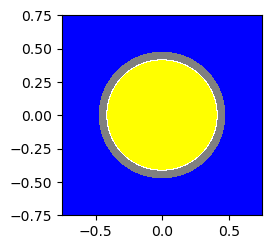

In [13]:
# Plot the fuel pin universe to make sure it looks correct

fp.plot(color_by='material',width=(1.5,1.5),colors=colors)

In [14]:
# define cells for a target pin universe

fuel_t = openmc.Cell(name='fuel_t');
fuel_t.region = fuel_region;
fuel_t.fill = target

gap_t = openmc.Cell(name='gap_t');
gap_t.region = gap_region;

clad_t = openmc.Cell(name='clad_t');
clad_t.fill = zirc4
clad_t.region = clad_region;

coolant_t = openmc.Cell(name='coolant_t');
coolant_t.fill = water
coolant_t.region = water_region # I probably should have called this a "coolant region"

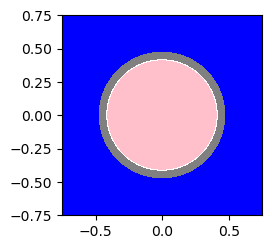

In [15]:
# define a target pin universe

tp = openmc.Universe()
tp.add_cells([fuel_t,gap_t,clad_t,coolant_t]);

tp.plot(color_by='material',width=(1.5,1.5),colors=colors)

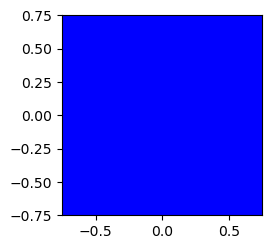

In [16]:
# We also want to define an "all coolant" universe to use with the lattice we will be making.

all_coolant_cell = openmc.Cell(name='all_coolant_cell')
all_coolant_cell.fill = water
# with no region, water will just be everywhere (I think!!)

cu = openmc.Universe()
cu.add_cells([all_coolant_cell]);

cu.plot(color_by='material',width=(1.5,1.5),colors=colors)

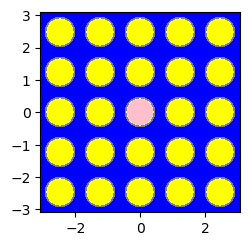

In [17]:
# create the assembly/core geometry

P_D = 1.3     # pitch/diameter ratio
N_assy = 5; # number of pins per dimension in the assembly, i.e. N_assy x N_assy 

pitch = r_co*2.*P_D; # cm, pin pitch
a_pitch = N_assy*pitch # cm, assembly pitch

h_assy = 100; # cm, height of the assembly model

assy_box = openmc.model.RectangularParallelepiped(-a_pitch/2.,a_pitch/2.,
                                                  -a_pitch/2.,a_pitch/2.,
                                                  -h_assy/2.,h_assy/2.,
                                                  boundary_type='reflective');
# other boundary types = 'periodic' and 'vacuum'

assy_lat = openmc.RectLattice()
assy_lat.center = (0.,0.)
assy_lat.dimension = [N_assy,N_assy]
assy_lat.lower_left = [-N_assy/2.*pitch,-N_assy/2.*pitch]
assy_lat.pitch = [pitch,pitch]
assy_lat.universes=[
    [fp, fp, fp, fp, fp],
    [fp, fp, fp, fp, fp],
    [fp, fp, tp, fp, fp],
    [fp, fp, fp, fp, fp],
    [fp, fp, fp, fp, fp]
]
assy_lat.outer = cu; # coolant universe is outside of the assy lattice.

assy_u = openmc.Universe()
assy_cell = openmc.Cell()
assy_cell.fill = assy_lat;
assy_cell.region = -assy_box
assy_u.add_cell(assy_cell);

# plot the assembly universe and make sure it looks right.
assy_u.plot(width=(a_pitch,a_pitch),color_by='material',colors=colors)


In [18]:
# create the geometry and export to XML

geometry = openmc.Geometry()
geometry.root_universe = assy_u

geometry.export_to_xml()


## Tallies

We need to add tallies so that we can measure neutron flux --- especially in the vicinity of the target -- and reaction rates.

In [19]:
# filters for energy, cells, and reactions
cell_filter = openmc.CellFilter(fuel_t); # measure in the target material cell

cell_filter_assy = openmc.CellFilter(assy_cell);

# energy bins
N = 1001;
energy_bins = np.logspace(-3,7,num=N);
energy_filter = openmc.EnergyFilter(values=energy_bins);

# establish a flux tally for the target
flux_target = openmc.Tally(name='flux in target');
flux_target.scores = ['flux'];
flux_target.filters = [cell_filter,energy_filter];

# avg flux for the whole core
flux_avg = openmc.Tally(name='avg flux')
flux_avg.scores = ['flux'];
flux_avg.filters = [cell_filter_assy, energy_filter];



# create a tally to estimate rate of conversion of Np-237 to Np-238
np237_capture_t = openmc.Tally(name='Np237_total_capture');
np237_capture_t.scores = ['(n,gamma)'];
np237_capture_t.nuclides=['Np237'];
efilter_values = [0.0, 1.0, 3.0e4, 14.0e6]; #OpenMC energy units are in eV
efilter_capture = openmc.EnergyFilter(values=efilter_values);
np237_capture_t.filters = [cell_filter,efilter_capture]

tallies = openmc.Tallies([flux_target,flux_avg,np237_capture_t]);
tallies.export_to_xml()


In [20]:
# create settings for criticality

settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 200;
settings.inactive = 50;

box = openmc.stats.Box(lower_left=(-a_pitch/2.,-a_pitch/2.,-h_assy/2.),
                      upper_right=(a_pitch/2.,a_pitch/2.,h_assy/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);
settings.source = src;

settings.export_to_xml();

In [21]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

      110/1    1.35696    1.35045 +/- 0.00148
      111/1    1.35596    1.35054 +/- 0.00146
      112/1    1.37677    1.35097 +/- 0.00150
      113/1    1.35471    1.35103 +/- 0.00148
      114/1    1.33329    1.35075 +/- 0.00148
      115/1    1.34708    1.35069 +/- 0.00146
      116/1    1.34481    1.35060 +/- 0.00144
      117/1    1.35205    1.35062 +/- 0.00142
      118/1    1.33695    1.35042 +/- 0.00141
      119/1    1.34105    1.35029 +/- 0.00140
      120/1    1.34660    1.35024 +/- 0.00138
      121/1    1.34726    1.35019 +/- 0.00136
      122/1    1.35879    1.35031 +/- 0.00134
      123/1    1.34352    1.35022 +/- 0.00133
      124/1    1.34315    1.35012 +/- 0.00131
      125/1    1.34206    1.35002 +/- 0.00130
      126/1    1.35308    1.35006 +/- 0.00128
      127/1    1.34691    1.35002 +/- 0.00127
      128/1    1.34618    1.34997 +/- 0.00125
      129/1    1.33189    1.34974 +/- 0.00126
      130/1    1.35637    1.34982 +/- 0.00124
      131/1    1.33664    1.34966 

## Process tally results

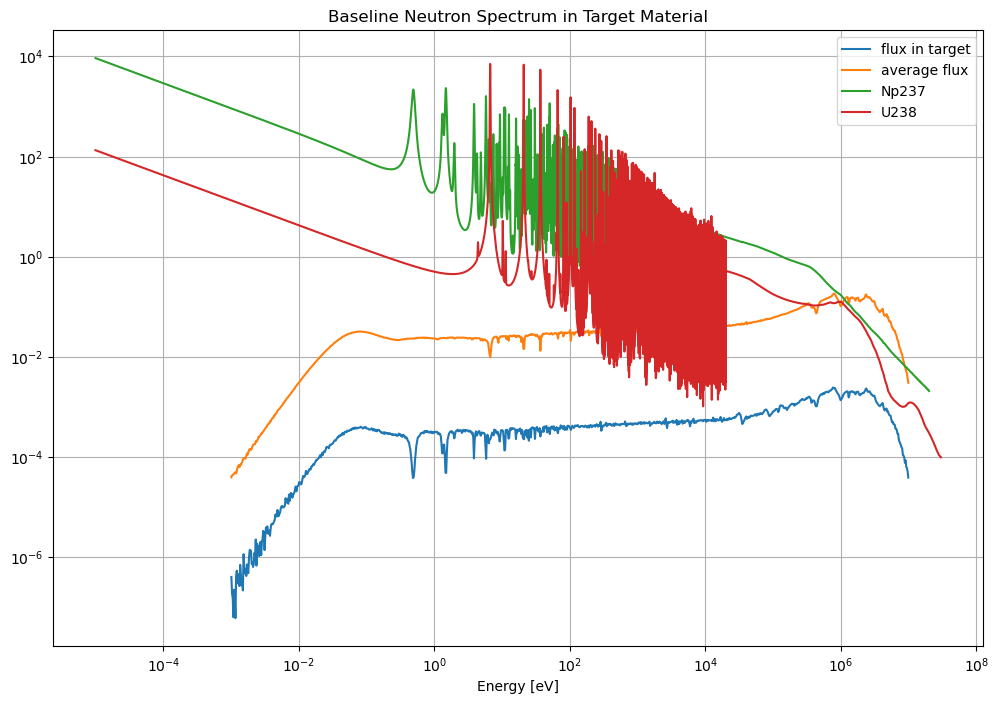

In [22]:
sp = openmc.StatePoint('statepoint.200.h5')

flux_t = sp.get_tally(name='flux in target')
flux_df = flux_t.get_pandas_dataframe()
flux_vals = flux_df['mean'].to_numpy()

flux_avg_t = sp.get_tally(name='avg flux')
flux_avg_df = flux_avg_t.get_pandas_dataframe()
flux_avg_vals = flux_avg_df['mean'].to_numpy()

energy_x = 0.5*(energy_bins[0:-1]+energy_bins[1:])

plt.loglog(energy_x,flux_vals,label='flux in target')
plt.loglog(energy_x,flux_avg_vals,label='average flux')
plt.loglog(np237_capture.xs['294K'].x,np237_capture.xs['294K'].y,label='Np237');
plt.loglog(u238_capture.xs['294K'].x,u238_capture.xs['294K'].y,label='U238');
plt.grid();
plt.legend();
plt.title('Baseline Neutron Spectrum in Target Material')
plt.xlabel('Energy [eV]');

In [23]:
np237_cap = sp.get_tally(name='Np237_total_capture')
np237_cap_df = np237_cap.get_pandas_dataframe();
np237_cap_vals = np237_cap_df['mean'].to_numpy();

tot_np237_capture = np237_cap_vals.sum();

print('Np237 thermal captures: %5.3f ' % np237_cap_vals[0]);
print('Np237 resonance captures: %5.3f ' % np237_cap_vals[1]);
print('Np237 high-energy captures: %5.3f ' % np237_cap_vals[2]);
print('Total Np237 captures per source particle: %5.3f. ' % tot_np237_capture);

Np237 thermal captures: 0.028 
Np237 resonance captures: 0.023 
Np237 high-energy captures: 0.001 
Total Np237 captures per source particle: 0.051. 


In [24]:
np237_cap_df.head()

,cell,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,5,0.0,1.0,Np237,"(n,gamma)",0.027562,0.000090
1,5,1.0,30000.0,Np237,"(n,gamma)",0.022952,0.000074
2,5,30000.0,14000000.0,Np237,"(n,gamma)",0.000734,0.000001
